In [2]:
import matplotlib.pyplot as plt
import numpy as np

def gr_dataset(X, y, title=None, show=True):
    """plot 2-class dataset. Different colors for different labels"""
    color = np.vectorize(lambda l: 'green' if l == 1 else 'blue')

    plt.scatter(*X.T, c=color(y))
    x = np.linspace(0, 1, 200)
    plt.ylim(0, 1)
    if title:
        plt.title(title)
    if show:
        plt.show()


def gr_classifier(classifier, X, y, margin=False, title="?"):
    """plot dataset and classifier margin"""

    # these are to plot the contour
    x_range = np.linspace(0, 1, 50)
    y_range = np.linspace(0, 1, 50)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    z = classifier.predict(np.array((np.ravel(x_grid), np.ravel(y_grid))).T)
    z_grid = z.reshape(x_grid.shape)

    plt.contour(x_grid, y_grid, z_grid, [0], colors='k')

    if margin:
        plt.contour(x_grid, y_grid, z_grid,
                    [-1, 1], colors='k', linestyles='dashed')

    gr_dataset(X, y, show=False)
    plt.title(title)
    plt.show()


In [3]:
import pandas as pd
from budgetsvm import optimization

df = pd.read_json("experiments/results/1680467315.4102345.json")

df["budget_percentage"] = df["model_name"].apply(
        lambda x: float(x.split("_")[0]) if "full" not in x else 1.0)

total_train_time_sec = df.train_time.sum()
df.train_time = df.train_time.div(60)
df = df.rename({"train_time": "train_time_min"}, axis=1)

df_success = df.dropna().copy()
#df_success = df.copy()
#df_success["score"] = df_success.score.apply(lambda x: x if type(x)==float else "0.0")

df_success = df_success.astype({
    "dataset": "string",
    "model_name": "string",
    "optimal": "bool",
    "params": "object",
    "score": "float",
    "budget": "float",
    "num_sv":"float",
    "train_time_min":"float",
})



full_budget_score = df_success.query("budget==inf")[["dataset","score"]]
df_success= df_success.join(full_budget_score.set_index("dataset"), on="dataset", rsuffix="_full_budget")
df_success["score_ratio"] = df_success["score"] / df_success["score_full_budget"]

df_success["dataset"] = df_success["dataset"].apply(lambda x: x[-10:])

df_success.sample(5)

,dataset,model_UUID,model_name,optimal,params,score,budget,num_sv,train_time_min,budget_percentage,score_full_budget,score_ratio
24,1a10b27bf9,d0d1e8a0-70e2-4b2c-a77d-25b8cdc31e43,full_budget,True,"{'C': 1.0, 'kernel': 'GaussianKernel(sigma=0.1)'}",0.966667,inf,67.0,0.365608,1.0,0.966667,1.000000
7,2ea62d334d,4d4b843c-72c3-4660-a850-9dec4131529c,0.30_budget,True,"{'C': 10.0, 'budget': 18, 'kernel': 'GaussianK...",0.466667,18.0,4.0,7.810971,0.3,0.911111,0.512195
40,8ba8202e51,9a2da916-e9a0-415c-bb86-5df7997623d3,full_budget,True,"{'C': 100.0, 'kernel': 'GaussianKernel(sigma=0...",0.977778,inf,28.0,0.373844,1.0,0.977778,1.000000
44,8ba8202e51,c0598c59-6485-4039-a1a0-e28bd878e3eb,0.60_budget,True,"{'C': 100.0, 'budget': 16, 'kernel': 'Gaussian...",0.977778,16.0,16.0,6.820065,0.6,0.977778,1.000000
26,1a10b27bf9,2d4e3c3e-e87e-4aca-9f71-5aae3ab2989c,0.80_budget,False,"{'C': 1.0, 'budget': 53, 'kernel': 'GaussianKe...",0.888889,53.0,15.0,20.345110,0.8,0.966667,0.919540


In [4]:
import datetime
print(f"{datetime.timedelta(seconds=total_train_time_sec)} tot. training time")

9:10:36.379736 tot. training time


In [5]:
df.dataset.unique()

array(['c909c284a99cdf44d8d51d2ea62d334d',
       '4866a56c176db9624e6d8bb02f2de8e1',
       '6340ead3f8a9ea762eaf5c2132fc757a',
       'ff89c17b0ee181abd72e691a10b27bf9',
       '96ee0f04878ee282e3470b3df861b457',
       '3cd89dab74b6d2f7f00cd48ba8202e51'], dtype=object)

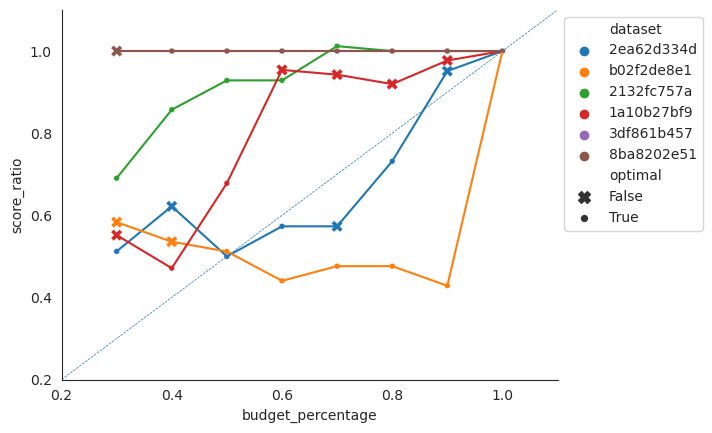

In [65]:
#for ds_id, group in df_success.groupby(["dataset"]):


fig, ax = plt.subplots()

sns.lineplot(
    data=df_success,
    x="budget_percentage", 
    y="score_ratio",
    hue="dataset",
    orient="x",
    legend=False,
    ax=ax
)
g = sns.scatterplot(
    data=df_success,
    x="budget_percentage", 
    y="score_ratio",
    hue="dataset",
    style="optimal",
    size="optimal",
    markers={True:"o", False:"X"},
    ax=ax
)
plt.axline((0, 0), (1,1), linestyle="--", linewidth=.5)

ax.set(xlim=(0.2, 1.1));
ax.set(ylim=(0.2, 1.1));

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

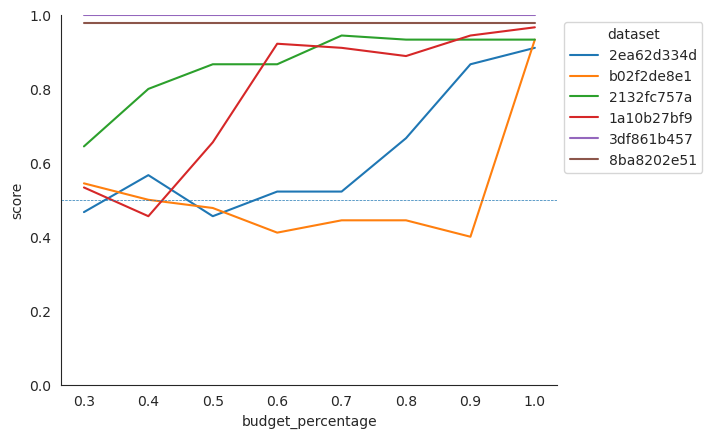

In [79]:
g = sns.lineplot(data=df_success, x="budget_percentage", y="score", hue="dataset")

plt.axhline(y=.5, linestyle="--", linewidth=.5)

g.set(ylim=(0.0, 1.0));

sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

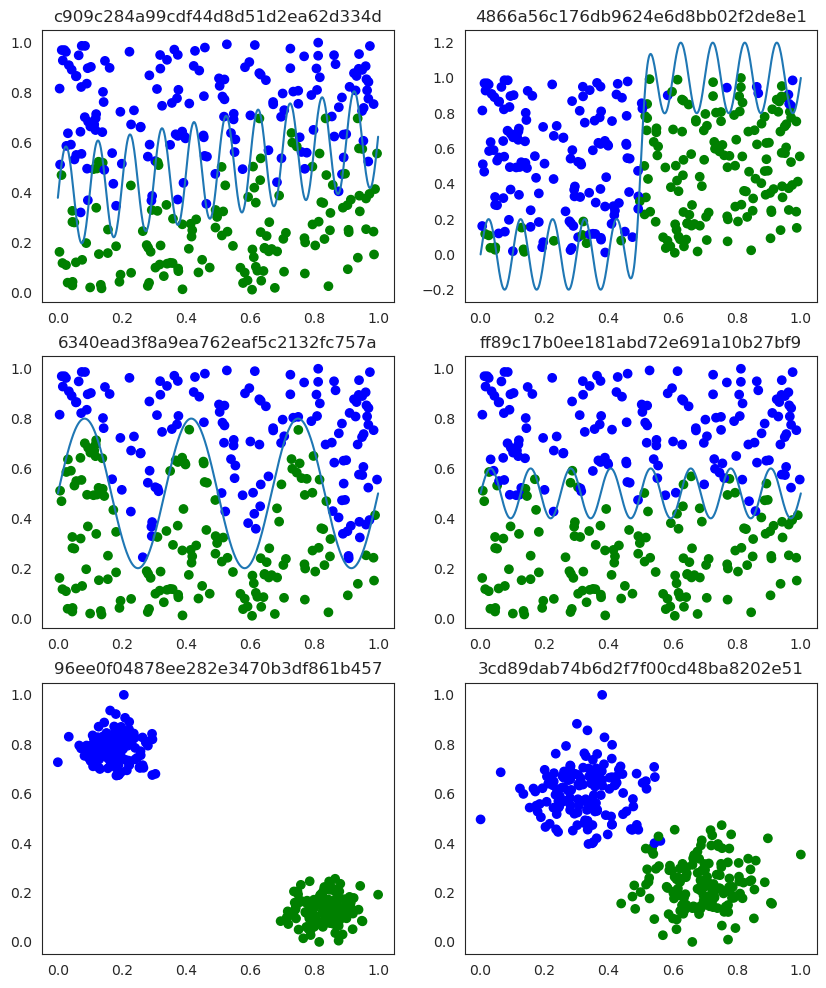

In [132]:
from experiments.datasets import load_dataset
from types import SimpleNamespace

def get_decision_function(beta, rho, theta):
    return lambda x:1 / (1 + np.exp(-beta * (x - 0.5))) + rho * np.sin(2 * np.pi * theta * x)


datasets = df.dataset.unique()

fig, axes = plt.subplots(3, 2, squeeze=False, figsize = (10,12))
for dh, ax in zip(datasets, axes.flatten()):
    ds = load_dataset(f"experiments/datasets/{dh}.json")
    
    ax.title.set_text(dh)
    
    color = np.vectorize(lambda l: 'green' if l == 1 else 'blue')
    ax.scatter(*ds.X.T, c=color(ds.y))
    x = np.linspace(0, 1, 200)
    
    if "beta" in ds.params:
        x_df = np.linspace(0, 1, 500)
        p = SimpleNamespace(**ds.params)
        y_df = get_decision_function(p.beta, p.rho, p.theta)(x_df)
        ax.plot(x_df, y_df)

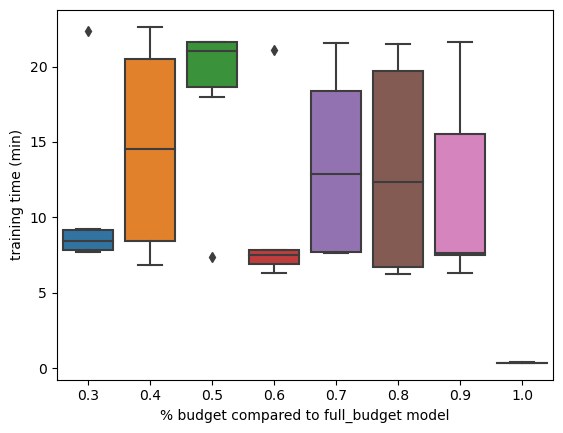

In [10]:
ax = sns.boxplot(
    data=df,
    x="budget_percentage",
    y="train_time_min"
)
ax.set(xlabel='% budget compared to full_budget model', ylabel='training time (min)');